In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Input, Model

raw_df = pd.read_excel("./data/FullDayWithAlarms.xlsx", header=1)
raw_df
# Rename columns for clarity
raw_df.rename(
    columns={
        "COD \nGIOCO": "Code_ID",
        "DATA ORA": "Timestamp",
        "INTERVALLO\nACQUISIZIONE": "Interval_s",
        "NUMERO\nTRANSAZIONI": "Num_Transactions",
        "TEMPO MIN": "Time_Min",
        "TEMPO MAX": "Time_Max",
        "TEMPO MEDIO": "Mean_Time",
        "NUMERO RETRY": "Num_Retries",
        "NUMERO \nTRANSAZIONI ERRATE": "Num_Wrong_Transactions",
    },
    inplace=True,
)

# # Parse and sort timestamps
raw_df["Timestamp"] = pd.to_datetime(
    raw_df["Timestamp"], dayfirst=True, errors="coerce"
)
raw_df.sort_values("Timestamp", inplace=True)
raw_df.reset_index(drop=True, inplace=True)


2025-05-15 18:36:15.164660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:36:15.171324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 18:36:15.186185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747326975.206463   16343 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747326975.212669   16343 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747326975.237088   16343 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
class VAE(Model):
    def __init__(self, encoder, decoder, window_size, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.window_size = window_size
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            rec_loss = tf.reduce_mean(tf.square(data - reconstruction)) * tf.cast(
                self.window_size, tf.float32
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}


def generate_synthetic_data(
    df,
    n_samples=500,
    window_size=30,
    latent_dim=8,
    epochs=50,
    batch_size=16,
    features=[
        "Num_Transactions",
        "Time_Max",
        "Mean_Time",
        "Num_Retries",
        "Num_Wrong_Transactions",
    ],
):
    # 1. Select and scale all features
    data = df[features].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    # 2. Create sliding windows of shape (window_size, n_features)
    X = np.array(
        [scaled[i : i + window_size] for i in range(len(scaled) - window_size)]
    )

    # 3. Build the encoder
    inputs = Input(shape=(window_size, len(features)))
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation="relu")(x)
    # x = layers.Dense(32, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    def sampling(args):
        mean, log_var = args
        # ignore predicted log_var, use a fixed sigma
        # fixed_sigma = 0.2
        sigma = tf.exp(0.1 * log_var)
        eps = tf.random.normal(shape=tf.shape(mean), mean=mean, stddev=0.7)  # default
        return mean + sigma * eps

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # 4. Build the decoder
    decoder_input = Input(shape=(latent_dim,))
    # x_dec = layers.Dense(32, activation='relu')(decoder_input)
    x_dec = layers.Dense(64, activation="relu")(decoder_input)
    x_dec = layers.Dense(window_size * len(features), activation="sigmoid")(x_dec)
    x_dec = layers.Reshape((window_size, len(features)))(x_dec)
    decoder = Model(decoder_input, x_dec, name="decoder")

    # 5. Compile & train the VAE
    #    original_dim = window_size * n_features for reconstruction loss
    vae = VAE(encoder, decoder, window_size * len(features))
    vae.compile(optimizer="adam")
    vae.fit(X, epochs=epochs, batch_size=batch_size, verbose=1)

    # 6. Sample latent vectors & decode
    z_samples = tf.random.normal((n_samples, latent_dim))
    X_synth = decoder.predict(z_samples)
    # Flatten all windows into one long series per feature
    X_synth = X_synth.reshape(n_samples * window_size, len(features))
    X_inv = scaler.inverse_transform(X_synth)
    X_inv = np.astype(X_inv, np.int64)

    # 7. Build synthetic DataFrame (taking first n_samples rows)
    synth = X_inv[:n_samples]
    synthetic_df = pd.DataFrame(synth, columns=features)
    synthetic_df["Timestamp"] = pd.date_range(
        end=df["Timestamp"].max(), periods=n_samples, freq="T"
    )

    return synthetic_df


Epoch 1/120


E0000 00:00:1747326979.751651   16343 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747326979.752879   16343 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 165.9095
Epoch 2/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.4406
Epoch 3/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.1769
Epoch 4/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.9261
Epoch 5/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.6538
Epoch 6/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.0609
Epoch 7/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22.3577
Epoch 8/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.0151
Epoch 9/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.3046
Epoch 10/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.9258
Epoch 11/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.8711
Epoch 12/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20.7990
Epoch 13/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.4387
Epoch 14/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.4371
Epoch 15/120
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.7023


/tmp/ipykernel_16343/4211710043.py:99: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  synthetic_df["Timestamp"] = pd.date_range(


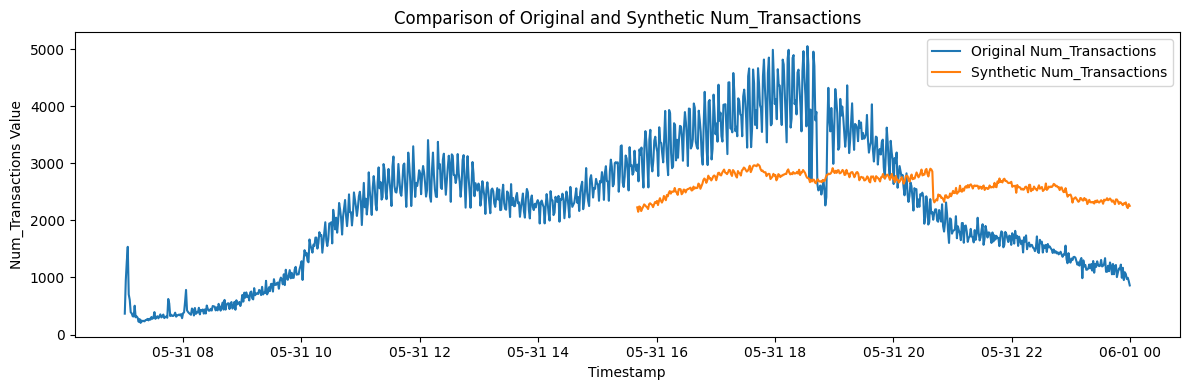

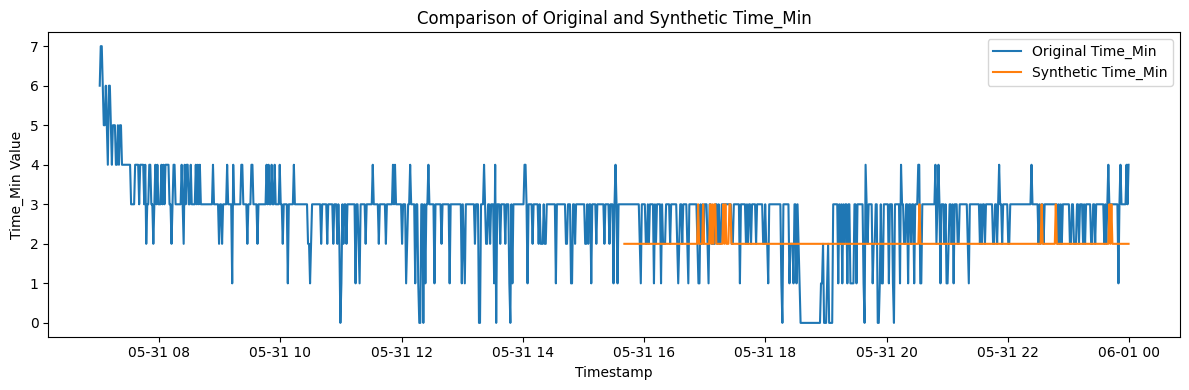

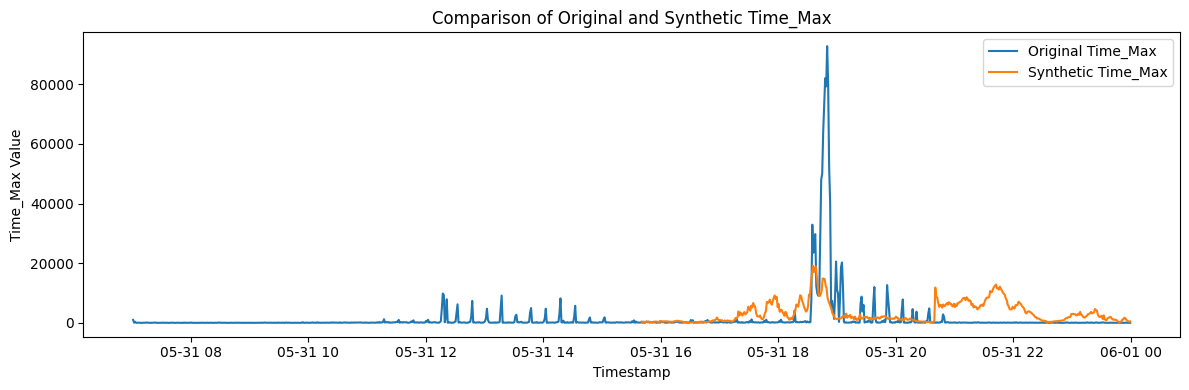

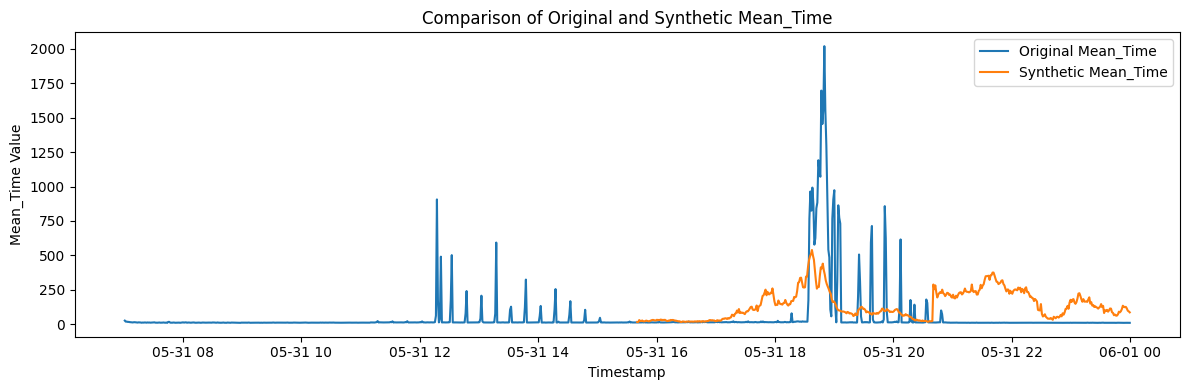

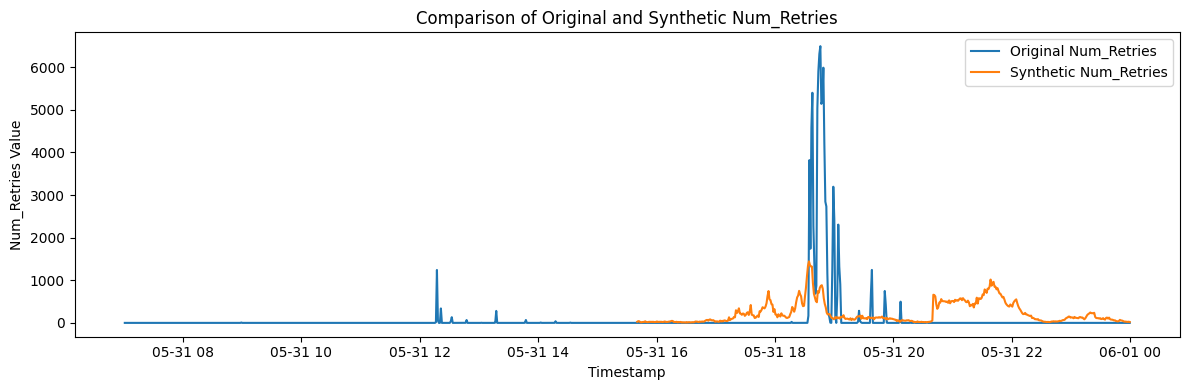

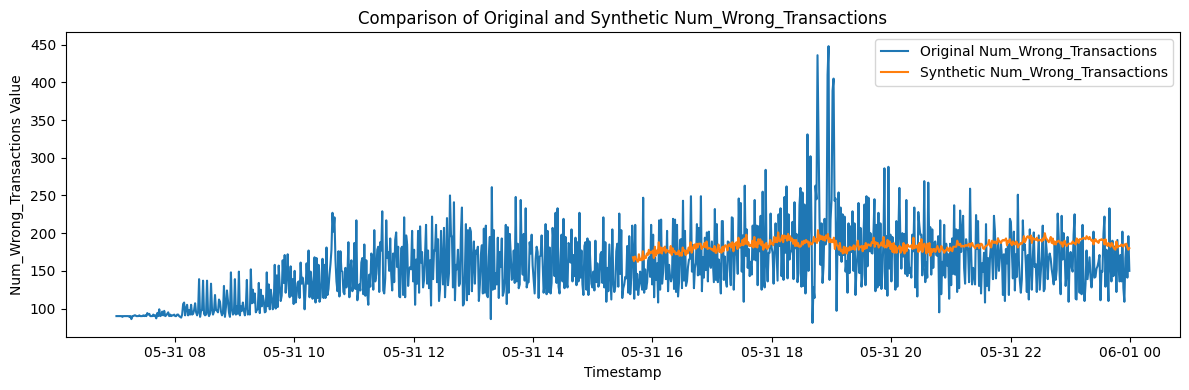

,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions,Timestamp
0,2230,2,462,16,26,168,2024-05-31 15:40:23
1,2152,2,285,15,40,163,2024-05-31 15:41:23
2,2246,2,468,30,38,169,2024-05-31 15:42:23
3,2236,2,355,24,19,166,2024-05-31 15:43:23
4,2165,2,288,22,14,164,2024-05-31 15:44:23
...,...,...,...,...,...,...,...
495,2317,2,1164,126,30,185,2024-05-31 23:55:23
496,2245,2,735,115,25,186,2024-05-31 23:56:23
497,2217,2,604,98,24,181,2024-05-31 23:57:23
498,2287,2,437,93,27,178,2024-05-31 23:58:23


In [3]:
features = [
    "Num_Transactions",
    'Time_Min',
    "Time_Max",
    "Mean_Time",
    "Num_Retries",
    "Num_Wrong_Transactions",
]

synth_df = generate_synthetic_data(
    raw_df, epochs=120, latent_dim=4, window_size=300, n_samples=500, features=features
)
print(f"synthetic data generated: {len(synth_df)} records")

for f in features:
    plt.figure(figsize=(12, 4))
    plt.plot(raw_df["Timestamp"], raw_df[f], label=f"Original {f}")
    plt.plot(synth_df["Timestamp"], synth_df[f], label=f"Synthetic {f}")
    plt.xlabel("Timestamp")
    plt.ylabel(f"{f} Value")
    plt.title(f"Comparison of Original and Synthetic {f}")
    plt.legend()
    plt.tight_layout()
    plt.show()
synth_df

In [4]:
synth_df

,Num_Transactions,Time_Min,Time_Max,Mean_Time,Num_Retries,Num_Wrong_Transactions,Timestamp
0,2230,2,462,16,26,168,2024-05-31 15:40:23
1,2152,2,285,15,40,163,2024-05-31 15:41:23
2,2246,2,468,30,38,169,2024-05-31 15:42:23
3,2236,2,355,24,19,166,2024-05-31 15:43:23
4,2165,2,288,22,14,164,2024-05-31 15:44:23
...,...,...,...,...,...,...,...
495,2317,2,1164,126,30,185,2024-05-31 23:55:23
496,2245,2,735,115,25,186,2024-05-31 23:56:23
497,2217,2,604,98,24,181,2024-05-31 23:57:23
498,2287,2,437,93,27,178,2024-05-31 23:58:23
